# About this notebook

Let's learn the forward kinematics and the inverse kinematics of the robot arm by moving our hands. We will explain how to construct forward kinematics using trigonometric functions and how to estimate joint angle using Newton's method.

Written by Yosuke Matsusaka (MID Academic Promotions, Inc. [@yosuke](https://twitter.com/yosuke))

This note is published under Creative Commons BY-SA license. ![CC BY-SA](http://i.creativecommons.org/l/by-sa/3.0/88x31.png)

# Preparation

This note is a hands-on type teaching material using the ipython notebook. On Ubuntu type following commands:
```
sudo apt-get install imagemagick asymptote graphviz
sudo pip3 install jupyter matplotlib sympy graphviz
jupyter notebook
```
to launch the environment.

Once you have launched the ipython notebook, please create a new notebook, and read the library for graph drawing and symbolic math processing as follows:

In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import Image
from sympy import *
init_printing()

Please enter the following code as well. This part will give us a magic of displaying animated GIF.

In [2]:
# Part of code is taken from: http://nbviewer.ipython.org/url/jakevdp.github.io/downloads/notebooks/AnimationEmbedding.ipynb
from tempfile import NamedTemporaryFile
import base64

GIF_TAG = """<img src="data:image/gif;bogus=ABCDEF;base64,{0}">"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.gif') as f:
            anim.save(f.name, writer='imagemagick', fps=4)
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video).decode('utf-8')
    return GIF_TAG.format(anim._encoded_video)

animation.Animation._repr_html_ = anim_to_html

Here, we will initialize the graph area. We will confirm the operation of the robot arm on this graph.

In [3]:
# Part of code is taken from: http://studywolf.wordpress.com/2013/09/20/python-visualization-with-matplotlib/
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, aspect='equal', autoscale_on=False,
                     xlim=(-1, 1), ylim=(-1, 1))
ax.grid()
line, = ax.plot([], [], 'o-', lw=4, mew=5)
infoline = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    infoline.set_text('')
    return line, infoline

The following is plotting library to draw description figures (installation is optional).

In [4]:
import graphviz

In [5]:
import subprocess # to run asymptote
import shlex

Let's get started.

# Forward kinematics of the robot arm

The term "forward kinematics" means the task to estimate the position of the robot hand when each joint angle of the robot arm is provided.

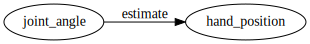

In [6]:
graphviz.Source('digraph G { rankdir=LR; joint_angle -> hand_position [label="estimate"] }')

People tends to think difficultly, because it contains the word "kinematics". However, the task is not so complex as described as the follows.

Calculate the forward kinematics, we need to know the structure of the robot arm. For this specific notebook we will select PA10-7C robot arm made by Mitsubishi Heavy Industries. Technical information of the arm has been published on the following pages.

https://www.mhi.co.jp/products/detail/pa10_6c_7c.html

The length of the links and joints of the robot arm are described in the following figure.

https://www.mhi.co.jp/products/detail/images/7c_mass.jpg

PA10 is the robot arm with 7 degree-of-freedom (7 joints). However for this specific notebook, we will take into account only the 2 degree-of-freedom (2 joints) on up and down direction to greatly simplify the model.

From Mitsubishi Heavy Industry's technical information, length between the first and the second joint from the root of PA10 is 450mm, length between the second joint and the hand is 480mm. By using this information, let's try to estimate the position of the hand given the angle of the first and the second joint.

In [7]:
f=open('/tmp/pa10-simplified.asy', 'w')
f.write('''
import math; import graph; import geometry;
size(12cm); xaxis("$x$"); yaxis("$y$");
real theta1=pi/4; real theta2=pi/3;
real L1=0.45; real L2=0.48;
pair l1p = (L1*sin(theta1), L1*cos(theta1));
pair l2p = l1p + (L2*sin(theta1+theta2), L2*cos(theta1+theta2));
draw((0,0)--l1p--l2p); draw(l1p--l1p*1.5, dashed); dot(l2p);
label("$J1(0,0)$", (0,0), NW); label("$J2(u,v)$", l1p, NW); label("$H(x,y)$", l2p, NE);
draw("$L1=450mm$",(0,0)-0.02*I*l1p--l1p-0.02*I*l1p, red, Arrows, Bars, PenMargins);
draw("$L2=480mm$", l1p-0.02*I*l2p--l2p-0.02*I*l2p, red, Arrows, Bars, PenMargins);
draw("$\theta_1$", arc((0,1),(0,0),l1p,0.1), blue, PenMargins);
draw("$\theta_2$", arc(l1p,0.1,degrees(l1p),degrees(l2p-l1p),CW), blue, PenMargins);
''')
f.close()
subprocess.call(shlex.split('asy /tmp/pa10-simplified.asy -f png -o pa10-simplified.png'))

![PA10 simplified](pa10-simplified.png)

First we define the angle of each joint as a variable.

In [8]:
t1 = Symbol('theta_1')
t2 = Symbol('theta_2')

We define the distance between each joint as a constant.

In [9]:
L1 = Symbol('L_1')
L2 = Symbol('L_2')

Before estimating the position of the hand, We first estimate the position of the second joint. Position of the second joint will be calculated in the following manner using the trigonometric functions.

In [10]:
u = L1 * sin(t1)
v = L1 * cos(t1)
[u, v]

Then we estimate the position of the hand. We add the distance to the hand to the position of the second joint.

In [11]:
x = u + L2 * sin(t1+t2)
y = v + L2 * cos(t1+t2)
[x, y]

Now the hand the position is estimated. We will confirm the result by drawing a graph.

In [12]:
import math

subs = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    t1: 0.0,
    t2: 0.0
}

def animate(i):
    if i < 10:
        subs[t1] = subs[t1] + math.pi / 30.0
    elif i < 20:
        subs[t2] = subs[t2] + math.pi / 30.0
    else:
        subs[t1] = subs[t1] - math.pi / 30.0
        subs[t2] = subs[t2] - math.pi / 30.0
    line.set_data([0, u.evalf(subs=subs), x.evalf(subs=subs)],
                  [0, v.evalf(subs=subs), y.evalf(subs=subs)])
    infoline.set_text('t1 = %.2f, t2 = %.2f' % (subs[t1], subs[t2]))
    return line, infoline

animation.FuncAnimation(fig, animate, frames=30,
                        interval=25, blit=True, 
                        init_func=init)

Seems there is no problem. Forward kinematics is now being solved.

# Inverse kinematics of the robot arm

The term "inverse kinematics" stands for the task to estimate the angle of each joint from the position of the hand. Just as the reverse of the forward kinematics.

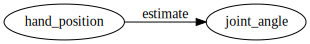

In [13]:
graphviz.Source('digraph G { rankdir=LR; hand_position -> joint_angle [label="estimate"] }')

It is necessary to calculate the inverse kinematics for the operations such as pick-and-place manipulating the robot arm freely. It will be somewhat more difficult than the forward kinematics, but it is yet not so difficult as you imagine from the word "kinematics".

There are two ways to calculate the inverse kinematics, one is analytical method and the other is numerical method.

## How to calculate inverse kinematics analytically

Since the forward kinematics is already given, what we have to do is to seek the opposite. In mathematical word, we have to find an inverse function. Analytical method tries to find such inverse function in a mathematical sense.

Forward kinematics is finally expressed as the following two equations.

In [14]:
[x, y]

In the analytical method, we will transform combine the expression like a puzzle with trial and error.

When converting the trigonometric functions, it have been known that it sometimes become better organized by summing the squared equations.

In [15]:
i = expand(x**2 + y**2)
i

This formula looks still complicated, but it can be greatly simplified by using the each theorem of trigonometric function shown below.

Pythagorean theorem: $ cos^2 \theta + sin^2 \theta = 1 $

Addition theorem: $ cos(\alpha - \beta) = cos(\alpha) cos(\beta) + sin(\alpha) sin(\beta) $

Based on these knowledge, we will use sympy to organize the equation automatically (yes, I am lazy).

In [16]:
j = simplify(i)
j

After the simplification, $\theta_1$ disappears (such thing will not always happen, but we are lucky in this case).

Calculation of the inverse function becomes easy after we converted to a simple formula. $\theta_2$ will be solved by using the $cos$ inverse function $acos$ as the follows. Here we get two solutions, we will discuss about this later.

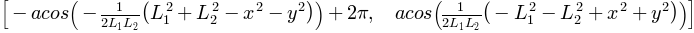

In [17]:
from sympy.solvers import solve
x2 = Symbol('x')
y2 = Symbol('y')
j2 = (x2**2 + y2**2)
k = solve(j2 - j, t2)
k

> FYI note:
> The sympy "solve" function provides us a high-performance solving algorithm. Why don't we solve the inverse kinematics directly by using this function? However, it can not be solved automatically given the forward kinematics equation of the original form. This not is because sympy is low-performance, but the conversion necessary to solve inverse kinematics is fairly complex. At the end of this notebook, we have information on the recently developed powerful libraries such as IKFast which has a function to express the kinematic structure of the robot in easily solvable form and solve inverse kinematics automatically by applying several conversion techniques specialized for kinematics.

We got $\theta_2$ already, so let's calculate $\theta_1$. Here, we solve by using the law of cosines.

First, we draw the auxiliary line from the first joint to the hand, and let the angle formed by the auxiliary line and the $x$ axis as $\alpha$.

In [18]:
f=open('/tmp/pa10-firstjoint.asy', 'w')
f.write('''
import math; import graph; import geometry;
size(12cm); xaxis("$x$"); yaxis("$y$");
real theta1=pi/4; real theta2=pi/3;
real L1=0.45; real L2=0.48;
pair l1p = (L1*sin(theta1), L1*cos(theta1));
pair l2p = l1p + (L2*sin(theta1+theta2), L2*cos(theta1+theta2));
draw((0,0)--l1p--l2p); draw(l1p--l1p*1.5, dashed); dot(l2p); draw((0,0)--l2p, dashed); 
label("$J1(0,0)$", (0,0), NW); label("$J2(u,v)$", l1p, NW); label("$H(x,y)$", l2p, NE);
draw("$L1$",(0,0)-0.02*I*l1p--l1p-0.02*I*l1p, red, Arrows, Bars, PenMargins);
draw("$L2$", l1p-0.02*I*l2p--l2p-0.02*I*l2p, red, Arrows, Bars, PenMargins);
draw("$\\theta_1$", arc((0,1),(0,0),l1p,0.1), blue, PenMargins);
draw("$\\theta_2$", arc(l1p,0.1,degrees(l1p),degrees(l2p-l1p),CW), blue, PenMargins);
draw("$\\alpha$", arc((1,0),(0,0),l2p,0.2), blue, PenMargins);
''')
f.close()
subprocess.call(shlex.split('asy /tmp/pa10-firstjoint.asy -f png -o pa10-firstjoint.png'))

![PA10 fist joint](pa10-firstjoint.png)

$\alpha$ can be expressed by using $atan$ as the follows.

In [19]:
alpha = atan(y2/x2)
alpha

Further

In [20]:
beta = pi / 2 - t1 - alpha
beta

Assuming a corner $\beta$ described as the above, we can draw following triangle with a focus on the second joint.

In [21]:
f=open('/tmp/pa10-secondjoint.asy', 'w')
f.write('''
import math; import graph; import geometry;
size(12cm); xaxis("$x$"); yaxis("$y$");
real theta1=pi*0.327; real theta2=pi/3;
real L1=0.45; real L2=0.48;
pair l1p = (L1*sin(theta1), L1*cos(theta1));
pair l2p = l1p + (L2*sin(theta1+theta2), L2*cos(theta1+theta2));
draw((0,0)--l1p--l2p); draw(l1p--l1p*1.5, dashed);
label("$J1(0,0)$", (0,0), NW); label("$J2(u,v)$", l1p, NW); label("$H(x,y)$", l2p, NE);
draw("$L1$",(0,0)-0.02*I*l1p--l1p-0.02*I*l1p, red, Arrows, Bars, PenMargins);
draw("$L2$", l1p-0.02*I*l2p--l2p-0.02*I*l2p, red, Arrows, Bars, PenMargins);
draw("$\\theta_2$", arc(l1p,0.1,degrees(l1p),degrees(l2p-l1p),CW), blue, PenMargins);
draw("$\\beta$", arc((1,0),(0,0),l1p,0.15), blue, PenMargins);
''')
f.close()
subprocess.call(shlex.split('asy /tmp/pa10-secondjoint.asy -f png -o pa10-secondjoint.png'))

![PA10 second joint](pa10-secondjoint.png)

Between $\beta$ and $\theta_2$ following relationship should exist from cosine theorem (the same way of thinking when decompose the triangle to derive the theorem).

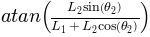

In [22]:
beta2 = atan((L2 * sin(t2))/(L1 + L2 * cos(t2)))
beta2

By combining the above equation to the $\beta$ formula, $\theta_1$ can be calculated in the following manner.

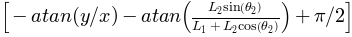

In [23]:
k2 = solve(beta2 - beta, t1)
k2

Now both $\theta_1$ and $\theta_2$ should be solved. To make sure, we draw the movement in the graph. Let's let the robot to draw the trajectory of the triangle.

In [24]:
subs = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    x2: 0.2,
    y2: 0.2
}

subs2 = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    t1: 0.0,
    t2: 0.0
}

def animate(i):
    if i < 10:
        subs[x2] = subs[x2] + 0.04
    elif i < 20:
        subs[y2] = subs[y2] + 0.04
    else:
        subs[x2] = subs[x2] - 0.04
        subs[y2] = subs[y2] - 0.04
    subs2[t2] = subs[t2] = k[0].evalf(subs=subs)
    subs2[t1] = k2[0].evalf(subs=subs)
    line.set_data([0, u.evalf(subs=subs2), x.evalf(subs=subs2)],
                  [0, v.evalf(subs=subs2), y.evalf(subs=subs2)])
    infoline.set_text('x = %.2f, y = %.2f' % (subs[x2], subs[y2]))
    return line, infoline

animation.FuncAnimation(fig, animate, frames=30,
                        interval=25, blit=True, 
                        init_func=init)

The trajectory of a triangle is drawn correctly by the robot hand. But if we imagine the real PA10 robot, elbow of the robot will hit the ground. In the above calculation $\theta_2$ had two solutions. So, let's draw a graph using the second solution.

In [25]:
subs = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    x2: 0.2,
    y2: 0.2
}

subs2 = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    t1: 0.0,
    t2: 0.0
}

def animate(i):
    if i < 10:
        subs[x2] = subs[x2] + 0.04
    elif i < 20:
        subs[y2] = subs[y2] + 0.04
    else:
        subs[x2] = subs[x2] - 0.04
        subs[y2] = subs[y2] - 0.04
    subs2[t2] = subs[t2] = k[1].evalf(subs=subs)
    subs2[t1] = k2[0].evalf(subs=subs)
    line.set_data([0, u.evalf(subs=subs2), x.evalf(subs=subs2)],
                  [0, v.evalf(subs=subs2), y.evalf(subs=subs2)])
    infoline.set_text('x = %.2f, y = %.2f' % (subs[x2], subs[y2]))
    return line, infoline

animation.FuncAnimation(fig, animate, frames=30,
                        interval=25, blit=True, 
                        init_func=init)

Now we get much preferred behavior. We can also understand the meaning of two solutions that came out. Even to realize the same hand coordinate, multiple solutions depending on the position of the elbow is possible due to the redundant degrees of freedom of the robot. Mathematically, both are correct. However in practice, there is a intended position of the elbow so we need to choose either solution.

> FYI note:
> The "position of the elbow" of the robot can become a big problem. This time the ground is the problem, however, if we want to extend the robot arm in a narrow space, we have to take care both the hand and the elbow must not hit the obstacle. In this specific notebook we assumed the two-degree-of-freedom robot, however, it is also possible to design the robot with further redundant degrees of freedom. Such a robot has wide range of freedom the position of the elbow to realize the same hand coordinate. We can make an interesting robot since it is possible to proceed while avoiding obstacles to control the position of the elbow even in a narrow space, while on the other hands calculation of inverse kinematics becomes much challenging.

> FYI note 2:
> However in practice, if we use a robot with high redundant degree of freedom, not only the calculation of inverse kinematics become difficult, but also, securing of hand coordinate accuracy become difficult because the backlash of each motor and distortion of each link will be accumulated. In practice, we try to make high degree of freedom of the robot at the same time from the simple kinematics. "SCARA robot" is one of such robot. In SCARA robot, xy-axis has the same structure as the two-degree-of-freedom robot we calculated in this notebook. There is additional z-axis direction linear joint close to the hand. Thanks to this structure, mechanical rigidity is easily secured, and it is an excellent design of the robot that can balance the high precision control and the ease of kinematic calculation.

## Numerical method to solve inverse kinematics

We have already studied how to calculate inverse kinematics using "analytical method" which takes the mathematical approach to calculate inverse function. But I think it was pretty tiring work even for the greatly simplified robot like we assumed here. If we want to calculate the joint angles of the complex robot with complex kinematics will be even more difficult task.

In the analytical method, we tried to calculate joint angles using an inverse function. However, without using the inverse function, we can calculate the joint angles by iterative calculations using computer. Such method is called "numerical method". Here, we will explain the example of using Newton's method.

In Newton's method, we will approach to the solution by the following way.

First of all, we give the appropriate initial value to the joint angles. "Appropriate value" is difficult than we think, but lets say we set a random value that was determined by shaking a dice.

$$ \theta_1 = initial value $$

From the initial value of the joint angles, we calculate the hand coordinate by using the formula in forward kinematics.

$$ r_1 = f(\theta_1) $$

Except for the case where the initial value that we selected randomly was actually the correct answer, this hand coordinate should be different from the target coordinate.

We calculate the difference between the target coordinate and the current hand coordinate. This value will measure how the current coordinate and the target coordinate is distant in either direction in the xy-axis of the hand coordinate system.

$$ r - r_1 $$

Although, we obtained the measure in the hand coordinate system, we have to the decrease the measure by adjusting joint angles of the robot. To do that, in the Newton's method we use a derivative of the function. By substituting the value of the current joint angle to the differentiation of the forward kinematics function, we will get constant which is proportion to "how much the xy-axis values in hand coordinate system will be changed by changing joint angle values".

$$ A_1 = f '(\theta_1) $$

Because the original forward kinematics formula contains trigonometric functions, this constant should make complex change depending on the joint angle. So the resulting constant only effective "in the vicinity of the current joint angle". But it is enough to make an approximation.

We use the above constant as the "glue" to connect the joint angle to the hand xy-axis coordinate system.

We place xy-axis hand coordinate system to the left side of the equation, the right side is the joint angle coordinate system and put them together with the glue. Here $r$ and $\theta$ is the respective target value of the hand coordinate and the joint angles.

$$ r - r_1 = A_1 (\theta - \theta_1) $$

Strictly speaking, this does not means this equality is established. But we try to think at this specific moment, the approximately holds such relationship.

Now we solve the above equation with respect to $\theta$.

$$ \theta = \theta_1 + A_1^{-1} (r - r_1) $$

By replacing $r_1$ and $A_1$ to the actual values we calculated from the forward kinematics, we will get the following equation which determining the correct joint angle $\theta$ from the target hand coordinate $r$ and the initial value $\theta_1$.

$$ \theta = \theta_1 + f'(\theta_1)^{-1} (r - f(\theta_1)) $$

Since $f '(\theta_1)$ is only an approximation near $\theta_1$, we improve the accuracy by calculating repeatedly as follows.

$$ \theta_{i+1} = \theta_i + k f'(\theta_i)^{-1} (r - f(\theta_i)) $$

Here, $k$ is the coefficient used when $A=f '(\theta)$ is not so creditable as an approximation (including our case). If this coefficient is set to small value, the approach to the solution will be little-by-little and required numbers of calculation will be increased, but can realize more reliable convergence.

Please note that in Newton's method, we can calculate the solution by using only the derivative of the function. Unlike the complex conversions required in analytical method to get inverse function, derivative of the function can be easily calculated.

In [26]:
xdt1 = diff(x, t1)
xdt2 = diff(x, t2)
ydt1 = diff(y, t1)
ydt2 = diff(y, t2)
j = [[xdt1, ydt1], [xdt2, ydt2]]
j

Lets calculate $A$ and $A^{-1}$ from a suitable initial value.

In [27]:
subs = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    t1: 0.1,
    t2: 0.1
}

A = Matrix([[xdt1.evalf(subs=subs), ydt1.evalf(subs=subs)], [xdt2.evalf(subs=subs), ydt2.evalf(subs=subs)]])
A

⎡0.918183831738908  -0.140286316272702 ⎤
⎢                                      ⎥
⎣0.470431957363796  -0.0953612787816294⎦

$A^{-1}$ is the inverse function of $A$, but it can be calculated easily because it is a constant. If $A$ is one-dimension

$$A^{-1} = \frac{1}{A}$$

But, here in our case the input and output of the system is 2-dimension because the expression is $r = (x, y)$ and $\theta = (\theta_1, \theta_2)$. Such case, $A$ will be a matrix. Inverse function (inverse matrix) of 2-dimension matrix can be calculated as follows.

$$A^{-1} = \begin{pmatrix} a & b \\ c & d \end{pmatrix}^{-1} = \frac{1}{ad-bc}\begin{pmatrix} d & -b \\ -c & a \end{pmatrix}$$

This apparently looks like a complex formula, but we can calculate them instantly because it is simply a multiplication and division of each matrix element.

In [28]:
AI = A.pinv()
AI

⎡4.42224073456897  -6.50557406790228⎤
⎢                                   ⎥
⎣21.8155984407579  -42.5794409892144⎦

In this specific notebook we use function pinv() to calculate pseudo-inverse matrix instead of function inv() to calculate normal inverse matrix. To explain in brief, the stability of the calculation can be improved by using pseudo-inverse matrix in such a state in which the hand of the robot is fully extended.

Let's write a program to find a solution by calculating literately.

In [29]:
subs = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    t1: 0.0,
    t2: 0.0
}

def newton(t1_initial, t2_initial, target_x, target_y, times):
    subs[t1] = t1_initial
    subs[t2] = t2_initial
    for i in range(0, times):
        A = Matrix([[xdt1.evalf(subs=subs), ydt1.evalf(subs=subs)], [xdt2.evalf(subs=subs), ydt2.evalf(subs=subs)]])
        AI = A.pinv()
        t1_next = subs[t1] + 0.1 * (AI[0,0]*(target_x - x.evalf(subs=subs)) + AI[0,1]*(target_y - y.evalf(subs=subs)))
        t2_next = subs[t2] + 0.1 * (AI[1,0]*(target_x - x.evalf(subs=subs)) + AI[1,1]*(target_y - y.evalf(subs=subs)))
        subs[t1] = t1_next
        subs[t2] = t2_next
    return [subs[t1], subs[t2]]

Let's confirm the result by drawing a graph.

In [30]:
subs2 = {
    L1: 450.0 / 1000.0,
    L2: 480.0 / 1000.0,
    t1: -0.5,
    t2: 3.0
}

target_x = 0.2
target_y = 0.2

def animate(i):
    global target_x, target_y
    if i < 10:
        target_x = target_x + 0.04
    elif i < 20:
        target_y = target_y + 0.04
    else:
        target_x = target_x - 0.04
        target_y = target_y - 0.04
    [subs2[t1], subs2[t2]] = newton(subs2[t1], subs2[t2], target_x, target_y, 10)
    line.set_data([0, u.evalf(subs=subs2), x.evalf(subs=subs2)],
                  [0, v.evalf(subs=subs2), y.evalf(subs=subs2)])
    infoline.set_text('x = %.2f, y = %.2f' % (target_x, target_y))
    return line, infoline

animation.FuncAnimation(fig, animate, frames=30,
                        interval=25, blit=True, 
                        init_func=init)

It seems it is correctly estimating the solution.

We have calculated the inverse kinematics by using a numerical method without having to derive the inverse function.

Newton's method is a very powerful algorithm that can approximate optimal parameters even for the very complex function which is difficult to derive an inverse function. Not only limited to robotic application, it is applied to wide variety of optimization problems.
On the other hand, we have to note that the convergence is not guaranteed in such method, but actually depend on how appropriate we can select the initial value. You need to take advantage of the method at the same time understanding their characters.

Although there are few characters to be cared when using the numerical method, we can easily calculate the inverse kinematics even for the robot with complex structure it only from some repetitive calculations. In recent years, performance the computer has significantly increased. Even the small embedded processor is capable to calculate the inverse kinematics at practical speed. From this background, numerical method has been widely used in many advanced robotic systems.

# Implementation to the robot

You might have expected the content of this notebook is programming with Python,  but probably have noticed it was actually a continuing transformation of the equations. But it is now over!

Finally we will program the above inverse kinematics in C ++ and control the robot.

In the [previous article (in Japanese)](http://tech.mid-japan.com/blog/2014/07/10/learn-pid-control-and-rtm/) we have already implemented a PID controller to PA10 robot and did the adjustment. In addition, we know that by using the middle-ware framework such as RTM, we can developed the system divided into parts which is called "component". This time we will try to compose a system of the following design by rearranging the PID controller was developed previously.

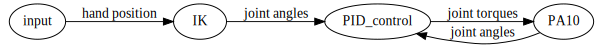

In [31]:
graphviz.Source('''
digraph G {
  rankdir=LR;
  input -> IK [label="hand position"]
  IK -> PID_control [label="joint angles"]
  PID_control -> PA10 [label="joint torques"]
  PA10 -> PID_control [label="joint angles"]
}
''')

The main part of today is the "inverse kinematics component" located at the center of the figure.

We have already calculated the inverse kinematics in both the analytical methods and numerical methods. Here, to thank to our valuable work on converting equations, let's implement our component using the analytical method.

We get the following formula as the final outcome obtained from the analytical method:

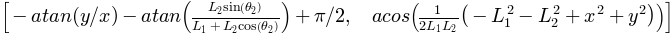

In [32]:
[k2[0], k[1]]

Implementation of this formula in C++ is as follows.

```cpp
#include <math.h>

#define L1 0.45
#define L2 0.48

double calc_t1(double x, double y, double t2) {
  double t1;
  t1 = - atan2(y, x) - atan2(L2*sin(t2), L1+L2*cos(t2)) + M_PI/2.0;
  return t1;
}

double calc_t2(double x, double y) {
  double t2;
  t2 = acos((-L1*L1 - L2*L2 + x*x + y*y)/(2*L1*L2));
  return t2;
}
```

The entire source code is available at the following repository.

https://github.com/devrt/inverse-kinematics-primer

Please first read file InverseKinematics.cpp, HandMotionGeneration.cpp, PIDController.cpp which is the source code of each component.

To start the simulation, it require hrpsys-base installed on Linux environment.
It is possible to launch the environment using the Vagrant environment, we have introduced [several times before] (tech.mid-japan.com/blog/2014/06/28/vagrant-hrpsys-watchdog/). It is recommended particular for those who are using Windows.

Once startup the environment and logged in, please checkout the repository and then start the script.

```
git clone https://github.com/devrt/inverse-kinematics-primer.git
cd inverese-kinematic-primer
./run.sh
```

Program to draw a triangular trajectory by the hand has been implemented as a default.

In [33]:
Image(url="http://devrt.tk/build/repo/53d8a5497466b5fd34fe25bb.gif")

It seems it has worked without problems.

Let's reach to the box by editing the HandMotionGeneration.cpp.

In [34]:
Image(url="http://devrt.tk/build/repo/53d8aa637466b5fd34fe25bd.gif")

We have successfully touched the box ! (It is also possible to pick a box, by using fingers. Please go ahead and try to modify the source code.)

# Appendix

In this specific notebook we have calculated and implemented the inverse kinematics formula from scratch. However, various libraries to solve the inverse kinematics already exist, because they are frequently used to control the robot.

Currently, the most popular library used in the robotics society is IKFast developed by Rosen Diankov.

http://openrave.org/docs/latest_stable/openravepy/ikfast/

IKFast can automatically the analytical solution given the structure of the robot (it internally uses sympy). It will also convert and output the solved equation to C++ code.

Because it is using analytical solution, the results of inverse kinematics is stable and work very fast.

To take advantage of the IKFast from ROS, you can use the following package.

http://moveit.ros.org/wiki/Kinematics/IKFast

Package utilize OpenRAVE (parent project of IKFast) from the RTM have been developed and published by Okada's lab (Tamagawa University).

https://code.google.com/p/rtc-openrave/


There is also a library to calculate the inverse kinematics in OpenHRP.

We have to be careful about the stability, because the inverse kinematics is calculated by numerical method, but it is very convenient because it can calculate the inverse kinematics from the same VRML model as used in the simulation.

http://www.openrtp.jp/openhrp3/jp/reference/idl/html/interfaceOpenHRP_1_1DynamicsSimulator.html

By using this library, you can create a demo application, such as the following video (see the source code used in this demo from the following link).

https://github.com/yosuke/OpenHRIWorlds/blob/master/openhriworlds/BlocksWorld.py

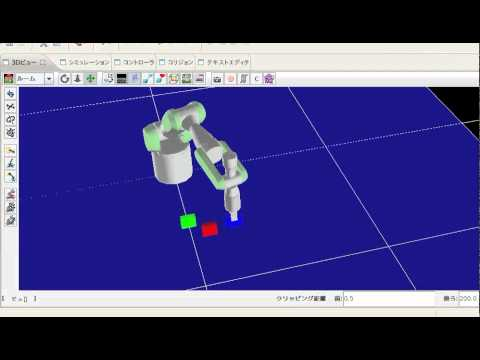

In [35]:
from IPython.display import YouTubeVideo
YouTubeVideo('HQBCnuJBs54')